# Сборный проект по анализу поведения пользователей мобильного приложения продуктов питания

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. 

План работы включает в себя следующие этапы:
- загрузка данных и изучение общей информации
- предобработка данных
- изучение и проверка данных
- изучение воронки событий (какая доля пользователей проходит на следующий шаг воронки; на каком шаге теряется больше всего пользователей; какая доля пользователей доходит от первого события до оплаты)
- изучение результатов эксперимента и проведение А/А/В-теста
- подведение итогов

## Загрузка данных и изучение общей информации

In [1]:
#импорт необходимых библиотек
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import math as mth

In [2]:
#выгрузка данных
try:
    df = pd.read_csv("C:/Users/Любовь/Downloads/logs_exp.csv", sep='\t')
except:
    df = pd.read_csv("https://code.s3.yandex.net/datasets/logs_exp.csv", sep='\t')

df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [3]:
part1 = df.shape[0]
part1

244126

**Промежуточные выводы:** в таблице с данными о событиях содержится 4 столбца и 244126 строк, пропусков не обнаружено. В данных есть недочеты, которые будут исправлены на следующем этапе.

## Предобработка данных

In [4]:
#изменение названия столбцов
df = df.rename(columns={'EventName':'event', 'DeviceIDHash':'user_id', 'EventTimestamp':'timestamp', 'ExpId':'exp_id'})

In [5]:
#добавление столбца даты и времени, а также отдельного столбца дат
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df['date'] = pd.to_datetime(df['datetime']).dt.date
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   event      244126 non-null  object        
 1   user_id    244126 non-null  int64         
 2   timestamp  244126 non-null  int64         
 3   exp_id     244126 non-null  int64         
 4   datetime   244126 non-null  datetime64[ns]
 5   date       244126 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 11.2+ MB


In [6]:
df = df.drop_duplicates()
part2 = df.shape[0]
print('Доля исключенных событий:', round(1 - part2/part1, 4))

Доля исключенных событий: 0.0017


In [7]:
#проверяем, есть ли пользователи, попавшие в несколько групп сразу
user_groups = df.groupby('user_id')['exp_id'].nunique()
user_groups = user_groups[user_groups > 1]
user_groups

Series([], Name: exp_id, dtype: int64)

**Промежуточные выводы:** в датафрейм добавила столбцы с датой и временем и отдельно с датой, изменила их типы на необходимые. Названия стобцов переименовала на удобные и оформила в одном стиле. Пропусков в данных нет. Были выявлены дубликаты, которые занимали 0.17% от всех данных, поэтому их смело удалила. Пользователей, попавших сразу в несколько групп, нет. Можно приступать к следующему этапу.

## Изучение и проверка данных

In [8]:
events = df['event'].count()
print('Всего событий в логе:', events)
print('Уникальных событий в логе', df['event'].nunique(), ':', df['event'].unique())

Всего событий в логе: 243713
Уникальных событий в логе 5 : ['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']


In [9]:
uniq_users = df['user_id'].nunique()
print('Всего пользователей в логе:', df['user_id'].count())
print('Уникальных пользователей в логе:', uniq_users)

Всего пользователей в логе: 243713
Уникальных пользователей в логе: 7551


In [10]:
print('Среднее количество событий на пользователя:', round(events/uniq_users, 1))

Среднее количество событий на пользователя: 32.3


In [11]:
min_data = df['datetime'].min()
max_data = df['datetime'].max()
print(f'Данные, которыми мы располагаем, представлены за период с {min_data} по {max_data}')
print(f'Всего дней: {max_data - min_data}')

Данные, которыми мы располагаем, представлены за период с 2019-07-25 04:43:36 по 2019-08-07 21:15:17
Всего дней: 13 days 16:31:41


<Figure size 864x576 with 0 Axes>

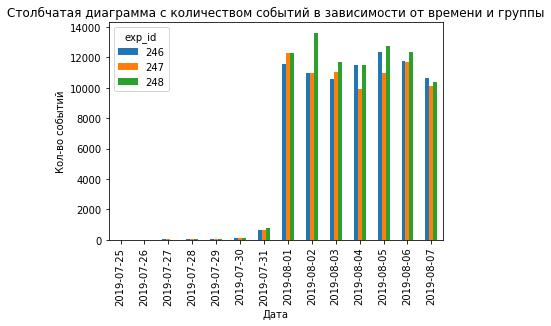

In [12]:
#создадим переменную, в которой сгруппируем данные по дате и группе, посчитаем кол-во событий
event_per_date = df.groupby(['date', 'exp_id'])['event'].count().reset_index()
pivot_data = event_per_date.pivot_table(index='date', columns='exp_id', values='event')

plt.figure(figsize=(12,8))
pivot_data.plot(kind='bar')
plt.xlabel('Дата')
plt.ylabel('Кол-во событий')
plt.title('Столбчатая диаграмма с количеством событий в зависимости от времени и группы')
plt.show();

In [13]:
df = df.loc[df['datetime'] >= '2019-08-01']
df.sort_values(by='datetime')

,event,user_id,timestamp,exp_id,datetime,date
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


In [14]:
part3 = df.shape[0]
print(f'Отбросив старые данные, было потеряно {round(1-part3/part2, 4)*100}% событий и пользователей')

Отбросив старые данные, было потеряно 1.16% событий и пользователей


In [15]:
df['exp_id'].value_counts()

248    84563
246    79302
247    77022
Name: exp_id, dtype: int64

In [16]:
df.groupby('exp_id')['user_id'].nunique()

exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

**Промежуточные выводы:** всего в логе было представлено 243713 событий (5 уникальных) и пользователей (7551 уникальных). А среднее количество событий на пользователя составило 32.3. Изначально данные представлены за период с 2019-07-25 по 2019-08-07 (т.е. за 13 полных дней), однако после построения столбчатой дитаграммы стало видно, что полной информацией мы обладаем только с 2019-08-01 (т.е. за 7 дней). Отбросив старые данные, было потеряно 1.16% событий и пользователей, что является вполне приемлемым. Во всех трех экспериментальных гпуппах находится примерно равное количество пользователей - около 80 тысяч, а уникальных - около 2500 в каждой.

## Изучение воронки событий

In [17]:
#посчитаем пользователей, совершавших каждое из событий, и их долю
funnel = df.groupby('event').agg({'event':'count', 'user_id':'nunique'}).sort_values(by='user_id', ascending=False)
funnel.columns = ['events', 'users']
funnel = funnel.reset_index()
all_users = df['user_id'].nunique()
funnel['part'] = round(funnel['users']/all_users, 3)
funnel

,event,events,users,part
0,MainScreenAppear,117328,7419,0.985
1,OffersScreenAppear,46333,4593,0.610
2,CartScreenAppear,42303,3734,0.496
3,PaymentScreenSuccessful,33918,3539,0.470
4,Tutorial,1005,840,0.111


In [18]:
#посчитаем долю пользователей, проходящих на каждый следующий этап воронки
funnel['conversion_per_step'] = round(funnel['users']/funnel['users'].shift(1), 3)
funnel['conversion'] = round(funnel['users']/funnel['users'].iloc[0], 3)
funnel

,event,events,users,part,conversion_per_step,conversion
0,MainScreenAppear,117328,7419,0.985,NaN,1.000
1,OffersScreenAppear,46333,4593,0.610,0.619,0.619
2,CartScreenAppear,42303,3734,0.496,0.813,0.503
3,PaymentScreenSuccessful,33918,3539,0.470,0.948,0.477
4,Tutorial,1005,840,0.111,0.237,0.113


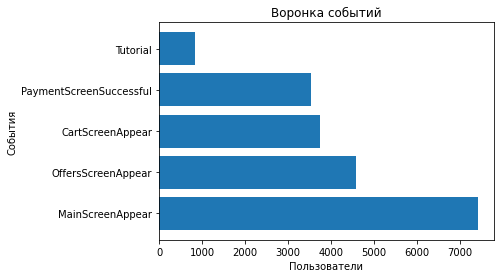

In [19]:
plt.barh(funnel['event'], funnel['users'])
plt.xlabel('Пользователи')
plt.ylabel('События')
plt.title('Воронка событий');

**Промежуточные выводы:** всего в логе 5 событий, 4 из них выстраиваются в последовательную цепочку: главное меню-экран предложений-корзина-оплата. Так и выглядит воронка, ведь после каждого этапа часть пользователей "отпадают". По графику видно, что больше всего "потерь" случается при переходе с главного меню на экран предложений - там может быть какая-то потенциальная проблема. Зато почти половина пользователей (47,7%) доходят с первого этапа до оплаты. Событие tutorial не сильно связано со всеми остальными и к нему юзеры могут обратиться на любом этапе, а при анализе воронки событий оно не сильно играет роль, судя по показателям.

## Изучение результатов эксперимента

In [20]:
#посчитаем кол-во пользователей в каждой группе
groups = df.groupby('exp_id')['user_id'].nunique()
groups['246+247'] = groups[246] + groups[247]
groups

exp_id
246        2484
247        2513
248        2537
246+247    4997
Name: user_id, dtype: int64

In [21]:
#составим таблицу со всеми группами и долями по событиями (не учитывая tutorial)
test = df.groupby(['event', 'exp_id']).agg({'user_id':'nunique'}).reset_index()
test_pivot = test[test['event']!='Tutorial'].pivot_table(index='event', columns='exp_id', values='user_id').sort_values(by=246, ascending=False)
test_pivot = test_pivot.reset_index()

test_pivot['246+247'] = test_pivot[246] + test_pivot[247]
test_pivot['all'] = test_pivot['246+247'] + test_pivot[248]
test_pivot['part_246'] = round(test_pivot[246]/groups[246],3)
test_pivot['part_247'] = round(test_pivot[247]/groups[247],3)
test_pivot['part_246+247'] = round(test_pivot['246+247']/groups['246+247'],3)
test_pivot['part_248'] = round(test_pivot[248]/groups[248],3)

test_pivot

exp_id,event,246,247,248,246+247,all,part_246,part_247,part_246+247,part_248
0,MainScreenAppear,2450,2476,2493,4926,7419,0.986,0.985,0.986,0.983
1,OffersScreenAppear,1542,1520,1531,3062,4593,0.621,0.605,0.613,0.603
2,CartScreenAppear,1266,1238,1230,2504,3734,0.510,0.493,0.501,0.485
3,PaymentScreenSuccessful,1200,1158,1181,2358,3539,0.483,0.461,0.472,0.466


Сформулируем гипотезы и проведем z-тест.

Нулевая: разницы между выборками 246 и 247 нет.

Альтернативная: статистически значимые различия в выборках есть.

Выбранный уровень статистической значимости:  alpha = 0.01

Так как я провожу 4 теста по одному набору данных, необходимо скорректировать уровень значимости поправкой Бонферрони: a corr = a/m = 0.01/4 = 0.0025 и вероятность накопительной ошибки FWER = 1 - (1-0.0025)^4 = 0.01.

In [22]:
#создадим функцию для проведения тестов
def z_test(group_1, group_2, alpha):
    for i in test_pivot.index:
        p1 = test_pivot[group_1][i] / groups[group_1]
        p2 = test_pivot[group_2][i] / groups[group_2]
        p = (test_pivot[group_1][i] + test_pivot[group_2][i]) / (groups[group_1] + groups[group_2])
        difference = p1 - p2
        z_value = difference / (mth.sqrt(p*(1 - p)*(1/groups[group_1] + 1/groups[group_2])))
        distr = st.norm(0,1)
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('p-значение для {}:'.format(test_pivot['event'][i]), p_value)
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

z_test(246, 247, 0.0025)

p-значение для MainScreenAppear: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение для OffersScreenAppear: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение для CartScreenAppear: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение для PaymentScreenSuccessful: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**А/А-тест был проведен для того, чтобы убедиться в качестве деления пользователей по группам - так как нулевую гипотезу отвергнуть не удалось, можно считать разделение успешным и переходить к А/В-тестированию.**

Нулевая: разницы между выборками 246 и 248 нет.

Альтернативная: статистически значимые различия в выборках есть.

Выбранный уровень статистической значимости: alpha = 0.0025

In [23]:
z_test(246, 248, 0.0025)

p-значение для MainScreenAppear: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение для OffersScreenAppear: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение для CartScreenAppear: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение для PaymentScreenSuccessful: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Нулевая: разницы между выборками 247 и 248 нет.

Альтернативная: статистически значимые различия в выборках есть.

Выбранный уровень статистической значимости: alpha = 0.0025

In [24]:
z_test(247, 248, 0.0025)

p-значение для MainScreenAppear: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение для OffersScreenAppear: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение для CartScreenAppear: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение для PaymentScreenSuccessful: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Нулевая: разницы между объединенными контрольными и экспериментальной группами нет.

Альтернативная: статистически значимые различия в выборках есть.

Выбранный уровень статистической значимости: alpha = 0.0025

In [25]:
z_test('246+247', 248, 0.0025)

p-значение для MainScreenAppear: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение для OffersScreenAppear: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение для CartScreenAppear: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение для PaymentScreenSuccessful: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Промежуточные выводы:** в каждой группе находится примерно равное количество пользователей - около 2500 человек. Самым популярным событием является открытие главного экрана. Для всех групп поситали долю пользователей, совершивших каждое из событий и проверили статистическую достоверность этого разбиения. При сравнении двух контрольных групп был выбран уровень значимости в 1%, так как тут требуется более жесткий подход. В остальных сравнениях был выбран стандартный alpha = 0.05. Ни в одном из сравнений не удалось отвергнуть нулевую гипотезу - не было оснований считать доли разными.  

## Общие выводы

В процессе анализа данных были выполнены следующие этапы, а также сделаны выводы по ним:
1. Загрузка данных и изучение общей информации
   - в таблице с данными о событиях содержится 4 столбца и 244126 строк
   - пропусков не обнаружено
2. Предобработка данных
   - добавлены столбцы с датой и временем и отдельно с датой
   - изменен тип данных там, где это необходимо
   - названия стобцов переименованы на удобные
   - выявлены и удалены дубликаты, которые занимали 0.17% от всех данных
   - пользователей, попавших сразу в несклько групп, не обнаружено
3. Изучение и проверка данных
   - всего в логе было представлено 243713 событий (5 уникальных) и пользователей (7551 уникальных)
   - среднее количество событий на пользователя составило 32.3.
   - данные представлены за период с 2019-07-25 по 2019-08-07 (т.е. за 13 полных дней)
   - полная информация содержится только с 2019-08-01 (т.е. за 7 дней)
   - были отброшены старые данные - 1.16% событий и пользователей
   - во всех трех экспериментальных гпуппах находится примерно равное количество пользователей - около 80 тысяч, а уникальных - около 2500
4. Изучение воронки событий
   - всего в логе 5 событий, 4 из них выстраиваются в последовательную цепочку: главное меню-экран предложений-корзина-оплата. Это и есть воронка событий
   - построен график, из которого видно, что больше всего "потерь" случается при переходе с главного меню на экран предложений - там может быть какая-то потенциальная проблема
   - почти половина пользователей (47,7%) доходят с первого этапа до оплаты
   - событие tutorial не сильно связано со всеми остальными и к нему юзеры могут обратиться на любом этапе, а при анализе воронки событий оно не сильно играет роль, судя по показателям
5. Изучение результатов эксперимента
   - проведен А/А-тест - разделение можно считать успешным, так как нулевую гипотезу отвергнуть не удалось
   - в каждой группе находится примерно равное количество пользователей - около 2500 человек
   - самым популярным событием является открытие главного экрана
   - для всех групп посчитали долю пользователей, совершивших каждое из событий и проверили статистическую достоверность этого разбиения
   - скорректирован уровень значимости поправкой Бонферрони, так как тест проводился 4 раза на одном наборе данных
   - во всех 4 статистических проверках между группами (двумя контрольными, каждой контрольной и экспериментальной, объединенными контрольными и экспериментальной) не удалось отвергнуть нулевую гипотезу - не было оснований считать доли разными
6. Вывод: статистически значимых отличий между группами нет, а значит изменения шрифта никак не повлияло на пользователей. Тест успешно завершен.